In [95]:
import numpy as np
import math
from PIL import Image


class SOM:
    def __init__(self, x_size, y_size, trait_num, t_iter, t_step):
        self.weights = np.random.randint(256, size=(x_size, y_size, trait_num)).astype('float64')
        self.t_iter = t_iter
        self.map_radius = max(self.weights.shape)/2
        self.t_const = self.t_iter/math.log(self.map_radius)
        self.t_step = t_step

    def show(self):
        im = Image.fromarray(self.weights.astype('uint8'), mode='RGB')
        im.format = 'JPG'
        im.show()

    def distance_matrix(self, vector):
        return np.sum((self.weights - vector) ** 2, 2)

    def bmu(self, vector):
        distance = self.distance_matrix(vector)
        return np.unravel_index(distance.argmin(), distance.shape)

    def bmu_distance(self, vector):
        x, y, rgb = self.weights.shape
        xi = np.arange(x).reshape(x, 1).repeat(y, 1)
        yi = np.arange(y).reshape(1, y).repeat(x, 0)
        return np.sum((np.dstack((xi, yi)) - np.array(self.bmu(vector))) ** 2, 2)

    def hood_radius(self, iteration):
        return self.map_radius * math.exp(-iteration/self.t_const)

    def teach_row(self, vector, i, dis_cut, dist):
        hood_radius_2 = self.hood_radius(i) ** 2
        bmu_distance = self.bmu_distance(vector).astype('float64')
        if dist is None:
            temp = hood_radius_2 - bmu_distance
        else:
            temp = dist ** 2 - bmu_distance
        influence = np.exp(-bmu_distance / (2 * hood_radius_2))
        if dis_cut:
            influence *= ((np.sign(temp) + 1) / 2)
        return np.expand_dims(influence, 2) * (vector - self.weights)

    def teach(self, t_set, distance_cutoff=False, distance=None):
        for i in range(self.t_iter):
            for x in t_set:
                self.weights += self.teach_row(x, i, distance_cutoff, distance)
        
    def distance_marix_optim(self, X):
        M,_ = np.shape(X)
        L1,L2,_ = np.shape(self.weights)
        X2 = np.sum(X**2, axis=1).reshape((M,1,1))
        W2 = np.sum(self.weights**2, axis=2).reshape((L1,L2,1))
        WX = self.weights.dot(X.T)
        dm = W2 - 2*WX + X2.T
        return dm
        
    def get_best_indices(self, X):
        dm = self.distance_marix_optim(X)
        indices = np.argmin(dm,axis=2)
        return indices
        
    def show_best_indices(self, X, indices=None):
        if indices is None:
            indices = self.get_best_indices(X)

In [104]:
s = SOM(200, 200, 3, 100, 0.1)
# t_set = np.array([[200, 0, 0], [0, 200, 0], [0, 0, 200], [120, 0, 100]])
t_set = np.random.randint(256, size=(15, 3))
s.teach(t_set)
s.show()

In [91]:
for i in range(10):
    s.teach(t_set)
    s.show()

In [86]:
s.teach(t_set)
s.show()

In [36]:
indices = s.get_best_indices(t_set)

In [37]:
indices[0,0]

2

In [39]:
s.show()

In [96]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata("MNIST original")
X_ = mnist.data
y_ = mnist.target

In [97]:
from sklearn.decomposition import PCA

rndperm = np.random.permutation(X_.shape[0])
X_rand = X_[rndperm]
y_rand = y_[rndperm]

pca = PCA(n_components=100)
X_complete = pca.fit_transform(X_rand)
y_complete = y_rand
print('Explained total variation: ,', format(sum(pca.explained_variance_ratio_)))

Explained total variation: , 0.9145726687387321


In [98]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib notebook
def plot_mxn(m,n,X):
    %matplotlib inline
    plt.gray()
    fig = plt.figure(figsize=(10, 10))
    gs = gridspec.GridSpec(m, n)
    gs.update(wspace=0.05, hspace=0.05)
    for i in range(m):
        for j in range(n):
            img = X[i,j]
            ax = plt.subplot(gs[i*n+j])
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            #ax.set_aspect('equal')
            plt.imshow(img.reshape((28,28)))
    plt.savefig('mnist-som.png')

In [102]:
ms = SOM(10, 10, 784, 100, 0.1)
ms.teach(X_rand[:10000])

In [100]:
mnist_indices = ms.get_best_indices(X_complete[:10000])

In [52]:
ms.teach(X[1000:2000])

In [53]:
ms.teach(X[2000:3000])

In [ ]:
ms.teach(X[3000:4000])

In [54]:
mnist_indices = ms.get_best_indices(X)

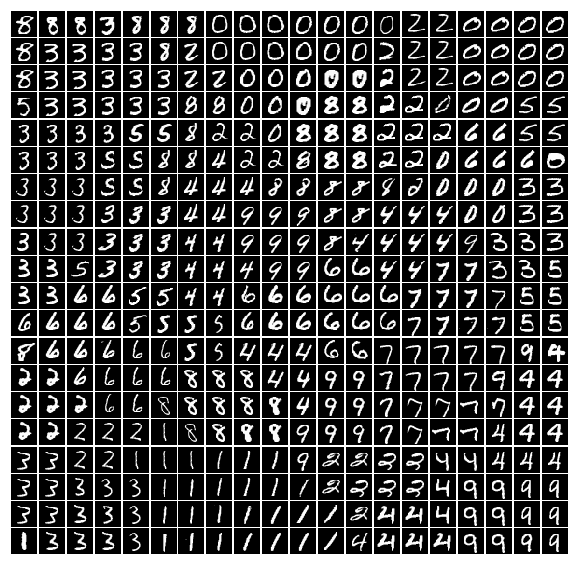

In [101]:
plot_mxn(20,  20,X_rand,mnist_indices)